*Run the below cell if using VGGFace as pre-trained model.*

In [1]:
# filename = "c:/users/kien/appdata/local/programs/python/python36/lib/site-packages/keras_vggface/models.py"
# text = open(filename).read()
# open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

# from keras_vggface.vggface import VGGFace

### 1. Import necessary packages and libraries

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from utils import save_figures

Constant variables.

In [3]:
# Exact name of your folders
CLASSES = ['angry', 'happy', 'neutral', 'sad', 'surprise']

N_CLASSES = len(CLASSES)
N_EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 128

TRAIN_DIR = 'data/FER/train/'
VAL_DIR = 'data/FER/test/'

### 2. Preprocess data

In [4]:
def preprocess_data(data_dir, labels=CLASSES, img_size=IMG_SIZE):
    # Read all images in dir folder
    data, X, y = [], [], []
    for category in labels:
        path = os.path.join(data_dir, category)
        category_idx = labels.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, category_idx])
            except Exception as e:
                pass
    # Shuffle data
    np.random.shuffle(data)
    for features, label in data:
        X.append(features)
        y.append(label)
    # Convert all images and their labels to NumPy arrays
    X, y = np.array(X), np.array(y)
    # Normalize data and one-hot encode the corresponding labels
    X = X / 255.0
    y = to_categorical(y, num_classes=N_CLASSES)
    return X, y

In [5]:
X_train, y_train = preprocess_data(data_dir=TRAIN_DIR)
X_val, y_val = preprocess_data(data_dir=VAL_DIR)

In [6]:
X_train.shape, X_val.shape

((24176, 128, 128, 3), (6043, 128, 128, 3))

Visualize an sample in the training data.

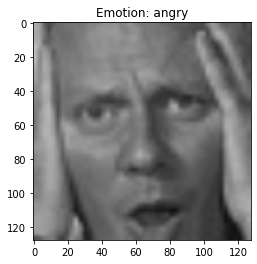

In [7]:
idx = np.random.randint(0, X_train.shape[0])
label = CLASSES[np.argmax(y_train[idx])]
plt.title(f'Emotion: {label}')
plt.imshow(X_train[idx])
plt.show()

### 3. Neural network architecture configuration

In [8]:
model = Sequential([
    # 1st layer
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.5),

    # 2nd layer
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.5),

    # 3rd layer
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.5),

    # Fully connected layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Final layer
    Dense(N_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        7

Build callback and compile model.

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
adam = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

### 4. Train model

In [10]:
history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=np.ceil(len(X_train)/BATCH_SIZE), 
    epochs=N_EPOCHS, 
    validation_data=(X_val, y_val), 
    validation_steps=np.ceil(len(X_val)/BATCH_SIZE), 
    callbacks=[early_stopping])

Epoch 1/50
1511/1511 [==============================] - 34s 21ms/step - loss: 1.5823 - acc: 0.2938 - val_loss: 1.5858 - val_acc: 0.2936
Epoch 2/50
1511/1511 [==============================] - 31s 21ms/step - loss: 1.5612 - acc: 0.2969 - val_loss: 1.5536 - val_acc: 0.3119
Epoch 3/50
1511/1511 [==============================] - 31s 20ms/step - loss: 1.4935 - acc: 0.3419 - val_loss: 1.4398 - val_acc: 0.3932
Epoch 4/50
1511/1511 [==============================] - 31s 20ms/step - loss: 1.4141 - acc: 0.3958 - val_loss: 1.3893 - val_acc: 0.4170
Epoch 5/50
1511/1511 [==============================] - 31s 21ms/step - loss: 1.3439 - acc: 0.4342 - val_loss: 1.2673 - val_acc: 0.4963
Epoch 6/50
1511/1511 [==============================] - 31s 21ms/step - loss: 1.2836 - acc: 0.4703 - val_loss: 1.1855 - val_acc: 0.5228
Epoch 7/50
1511/1511 [==============================] - 31s 21ms/step - loss: 1.2265 - acc: 0.4964 - val_loss: 1.1243 - val_acc: 0.5542
Epoch 8/50
1511/1511 [==========================

Save the history of accuracy and loss.

In [11]:
save_figures(history, dir='figures/')

Save model.

In [12]:
model.save('facial-expression-model.h5')

### 4. Model predictions

In [13]:
X_test, y_test = preprocess_data(data_dir='data/MMAFEDB/')

In [14]:
def visualize_predictions(X, y_preds, y_truths, to_show=6, num_col=3):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(6, 6))
    indices = random.sample(range(len(X)), to_show)
    for i, k in enumerate(indices):
        y_pred = CLASSES[np.argmax(y_preds[k])]
        y_truth = CLASSES[np.argmax(y_truths[k])]
        ax = axes[i % num_col] if num_row == 1 else axes[i // num_col, i % num_col]
        ax.imshow(X[k])
        ax.set_axis_off()
        ax.set_title(f'True: {y_truth} | Pred: {y_pred}')
    
    plt.tight_layout(rect=(0, 0, 2, 2), w_pad=5.0)
    plt.show()

In [15]:
y_preds = model.predict(X_test)

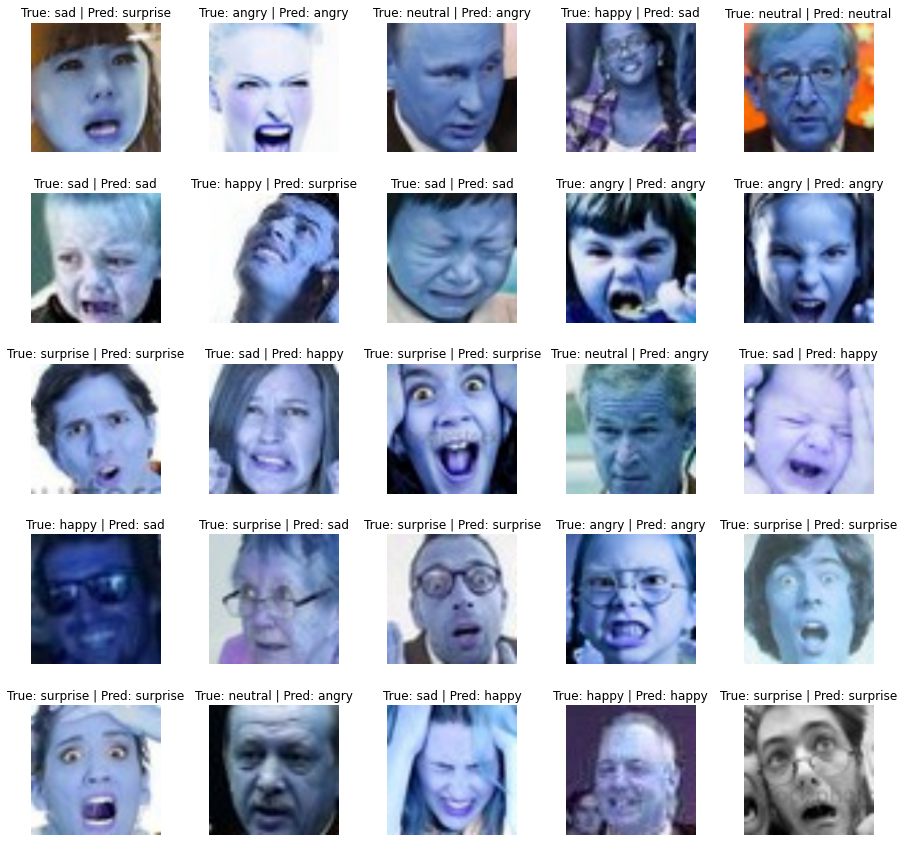

In [16]:
visualize_predictions(X_test, y_preds, y_test, to_show=25, num_col=5)